# Facies classification using Support Vector Machine
### (July 08, 2018)

## Project description

This Jupyter notebook tries to utilize Support Vector Machine (SVM) algorithm to perform supervised classification to predict lithofacies based on well-log measurements. This project is inspired by an article published in *The Leading Edge (Oct. 2016)*. As a first attempt, my goal here is to understand the data and to go through the whole machine learning flow with SVM classification. Results shown here are preliminary and are expected to be further improved. 

The raw dataset originated from the largest gas fields in North America, the Hugoton and Panoma Fields and was filtered for University of Kansas class exercise. This filtered datset will be used in this project. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011).

Input files used in this project:
* Input 1: 'traing_data.csv'   (data from 9 wells with known lithofacies: will be used for model training, parameter selection and model validataion)
* Input 2: 'validation_data_nofacies.csv'  (data from 2 wells without known lithofacies: will be used to predict Facies)

Both Input 1 & 2 contain the following 7 features, including 5 well-log measurements and 2 indicator variables, as described below. In addition, Input 1 has a Class label for lithofacies ('Facies') based on examination of cores from the 9 wells taken vertically at half-foot intervals. The task is to predict Class label 'Facies' at each depth for the 2 wells in Input 2.

The 5 well log measurements are:
  1. GR: Gamma Ray
  2. Resistivity (ILD_log10)
  3. Photoelectric effect (PE)
  4. Neutron-density porosity difference (DeltaPHI)
  5. Average neutron0density porosity (PHIND)
  
The 2 indicator variables (based on geological interpretation)
  6. Nonmarine/marine indicator (NM_M)
  7. Relative position (RELPOS)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('training_data.csv')
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [2]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,4.422030,2875.824567,66.135769,0.642719,3.559642,13.483213,3.725014,1.498453,0.520287
std,2.504243,131.006274,30.854826,0.241845,5.228948,7.698980,0.896152,0.500075,0.286792
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.918750,0.492750,1.163750,8.346750,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.721500,0.624437,3.500000,12.150000,3.551500,1.000000,0.526000
75%,6.000000,2980.000000,79.626250,0.812735,6.432500,16.453750,4.300000,2.000000,0.767250
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
Facies       3232 non-null int64
Formation    3232 non-null object
Well Name    3232 non-null object
Depth        3232 non-null float64
GR           3232 non-null float64
ILD_log10    3232 non-null float64
DeltaPHI     3232 non-null float64
PHIND        3232 non-null float64
PE           3232 non-null float64
NM_M         3232 non-null int64
RELPOS       3232 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.8+ KB


In [4]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS'],
      dtype='object')

In [5]:
df.index

RangeIndex(start=0, stop=3232, step=1)

In [6]:
df.corr()   # check correlations between variables

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
Facies,1.000000,0.340162,-0.344344,0.394493,-0.234064,-0.355905,0.704231,0.854654,0.068525
Depth,0.340162,1.000000,-0.064096,0.178039,-0.091391,-0.074373,0.277577,0.297085,0.001386
GR,-0.344344,-0.064096,1.000000,-0.155553,0.189977,0.248270,-0.289023,-0.281066,-0.173466
ILD_log10,0.394493,0.178039,-0.155553,1.000000,-0.117604,-0.522917,0.384589,0.519251,0.087962
DeltaPHI,-0.234064,-0.091391,0.189977,-0.117604,1.000000,-0.250211,0.011489,-0.173999,0.036579
PHIND,-0.355905,-0.074373,0.248270,-0.522917,-0.250211,1.000000,-0.573418,-0.488403,-0.034540
PE,0.704231,0.277577,-0.289023,0.384589,0.011489,-0.573418,1.000000,0.657089,0.018905
NM_M,0.854654,0.297085,-0.281066,0.519251,-0.173999,-0.488403,0.657089,1.000000,0.036607
RELPOS,0.068525,0.001386,-0.173466,0.087962,0.036579,-0.034540,0.018905,0.036607,1.000000


# Remove one well for later blind test
* df_blind & df_train

In [7]:
df_blind = df[df['Well Name'] == 'SHANKLE']
df_train = df[df['Well Name'] != 'SHANKLE']

In [8]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

In [9]:
facies_color_map

{'BS': '#196F3D',
 'CSiS': '#F5B041',
 'D': '#AED6F1',
 'FSiS': '#DC7633',
 'MS': '#1B4F72',
 'PS': '#A569BD',
 'SS': '#F4D03F',
 'SiSh': '#6E2C00',
 'WS': '#2E86C1'}

In [10]:
# create a new column 'FaciesLabels' using values from list 'facies_lables', using lambda for each row
def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
#df_train.loc[:,'FaciesLabels'] = df_train.apply(lambda row: label_facies(row, facies_labels), axis=1)
# The above is equivalent to
df_train['FaciesLabels'] = df_train.apply(lambda row: label_facies(row, facies_labels), axis=1)

C:\Users\yzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [11]:
df_train.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


# Raw data exploration

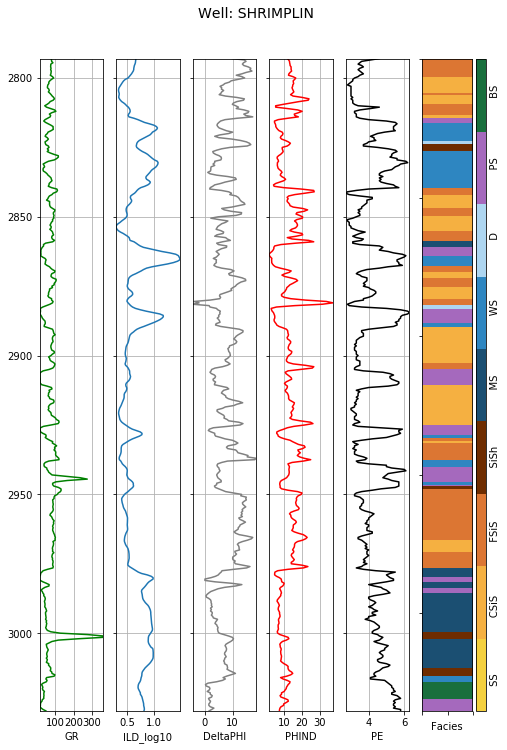

In [12]:
# show log plots for individual well SHRIMPLIN
#%matplotlib notebook

# call well_log_plot_utilities.py 
from well_log_plot_utilities import make_facies_log_plot

make_facies_log_plot(
    df_train[df_train['Well Name'] == 'SHRIMPLIN'],
    facies_colors)

# Check how various facies are represented by the entire training set

In [13]:
#count the number of unique entries for each facies, sort by facies number(instead of by number of entries)
#save as a pd series
facies_count = df_train['Facies'].value_counts().sort_index()

In [14]:
#set old numerical index with more meaningful discriptions
facies_count.index = facies_labels

In [15]:
facies_count.head()

SS      170
CSiS    649
FSiS    498
SiSh    177
MS      198
Name: Facies, dtype: int64

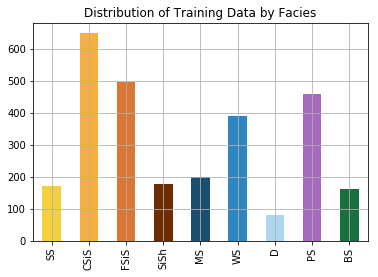

In [16]:
# make bar plot
#%matplotlib notebook
plt.figure()
facies_count.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

# facies_count.plot.bar() # default bar plot
facies_count.hist()  # add grids

# Check cross-plots

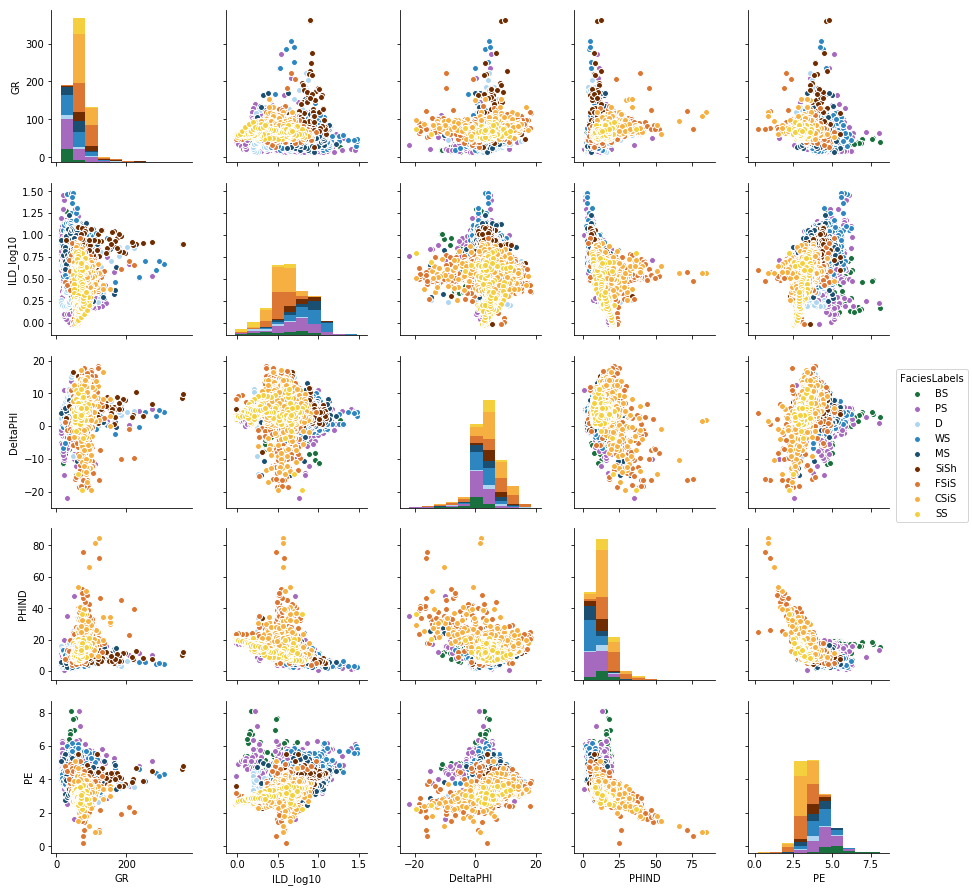

In [17]:
#%matplotlib notebook
import seaborn as sns

sns.pairplot(df_train.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))


<IPython.core.display.Javascript object>


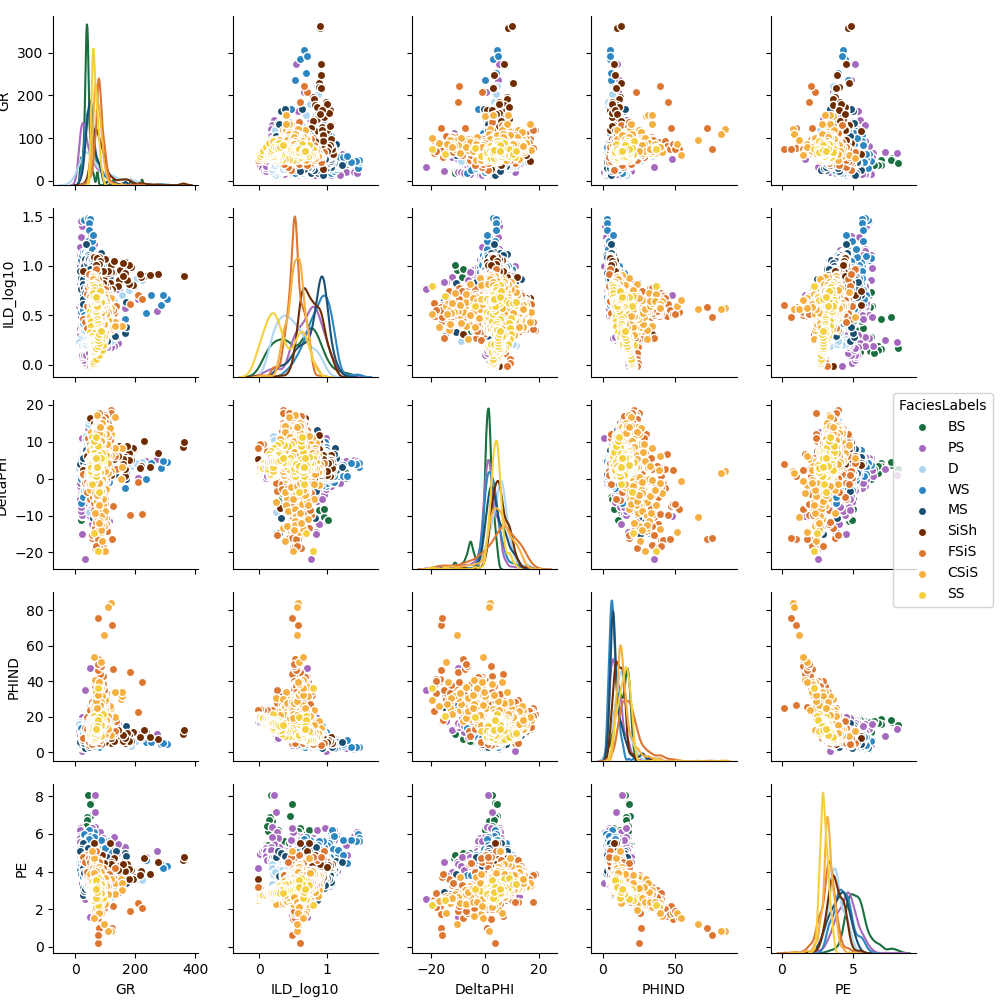

In [18]:
%matplotlib notebook
import seaborn as sns


g = sns.pairplot(df_train.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map, diag_kind='kde',
             hue_order=list(reversed(facies_labels)))

g.fig.set_size_inches(10,10)  # adjust pairplot size


# Conditioning the data set

Explore features we intend to use for classification. 

The predictor variables are the five wireline values (GR, ILD_log10, PE, DeltaPHI, PHIND) and two geologic constraining/indication variables (NM_M, RELPOS). We also get a vector of the facies labels that correspond to each feature vector.

In [19]:
# correct_facies_lables as ndarray
correct_facies_labels = df_train['Facies'].values 

# drop unwanted features, only keep 5 wireline variables and 2 geologic variables
feature_vectors = df_train.drop(['Formation', 'Well Name', 'Depth','Facies','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


In [20]:
# data whitening: normalize/scale/standardize features to make mean 0, variance 1
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)  # sklearn.preprocessing.data.StandardScalar
scaled_features = scaler.transform(feature_vectors)  # ndarray

In [21]:
feature_vectors.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000,2783.000000
mean,66.249445,0.644637,3.754963,13.118929,3.805693,1.523895,0.523057
std,31.610849,0.241922,5.045916,7.389665,0.894118,0.499518,0.287499
min,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,46.081500,0.497000,1.300000,8.165000,3.200000,1.000000,0.276500
50%,65.541000,0.627000,3.581000,11.900000,3.600000,2.000000,0.529000
75%,80.714000,0.812323,6.500000,16.144000,4.400000,2.000000,0.771500
max,361.150000,1.480000,18.500000,84.400000,8.094000,2.000000,1.000000


In [22]:
from pandas import set_option

# let pandas only display 10 rows
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

feature_vectors

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,77.450,0.664,9.900,11.915,4.600,1,1.000
1,78.260,0.661,14.200,12.565,4.100,1,0.979
2,79.050,0.658,14.800,13.050,3.600,1,0.957
3,86.100,0.655,13.900,13.115,3.500,1,0.936
4,74.580,0.647,13.500,13.300,3.400,1,0.915
...,...,...,...,...,...,...,...
3227,46.719,0.947,1.828,7.254,3.617,2,0.685
3228,44.563,0.953,2.241,8.013,3.344,2,0.677
3229,49.719,0.964,2.925,8.013,3.190,2,0.669
3230,51.469,0.965,3.083,7.708,3.152,2,0.661


# Split into training (X/y_train) & testing (X/y_test) datasets

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.1, random_state=42)

# Train SVM classifier w/ default parameters & X/y_train

In [24]:
from sklearn import svm

clf = svm.SVC() # Create a SVM classifier with default parameters
clf.fit(X_train,y_train)  # train the classifier using training data created


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Evaluate default SVM classifier X/y_test and with confusion matrix

In [25]:
predicted_labels = clf.predict(X_test)  # now predict

# Use confusion matrix to evaluate, by providing actual and predicted facies labels
from sklearn.metrics import confusion_matrix
#from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)  # confusion matrix 'conf' is 9x9 ndarray (conf.shape)
#display_cm(conf, facies_labels, hide_zeros=True)  # no module named classification_utilities?? Try new ways to display conf

Define functions to plot confusion matrix

<IPython.core.display.Javascript object>


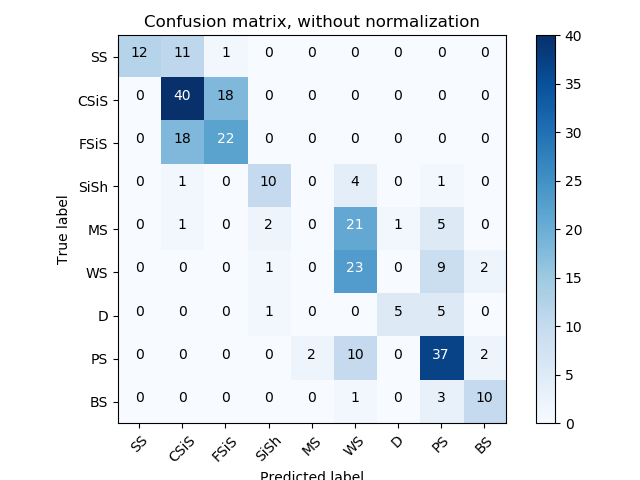

Confusion matrix, without normalization
[[12 11  1  0  0  0  0  0  0]
 [ 0 40 18  0  0  0  0  0  0]
 [ 0 18 22  0  0  0  0  0  0]
 [ 0  1  0 10  0  4  0  1  0]
 [ 0  1  0  2  0 21  1  5  0]
 [ 0  0  0  1  0 23  0  9  2]
 [ 0  0  0  1  0  0  5  5  0]
 [ 0  0  0  0  2 10  0 37  2]
 [ 0  0  0  0  0  1  0  3 10]]


In [26]:
# Plot un-normalized confusion matrix
# The rows of the confusion matrix correspond to the actual facies labels. 
# The columns correspond to the labels assigned by the classifier. 

from confusion_matrix_utilities import plot_confusion_matrix
plt.figure()
plot_confusion_matrix(conf, classes=facies_labels,
                      title='Confusion matrix, without normalization')

<IPython.core.display.Javascript object>


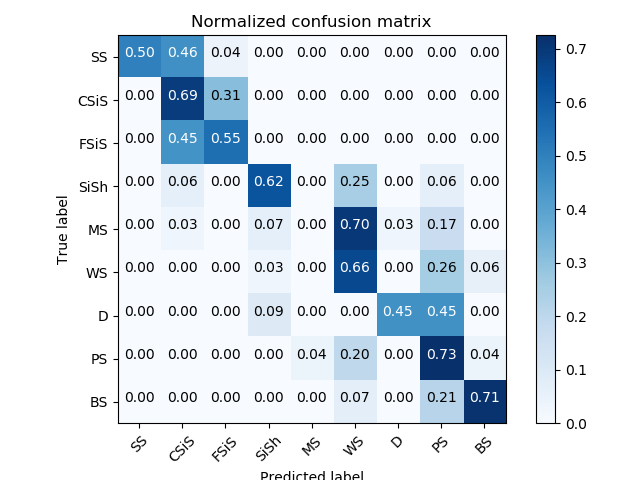

Normalized confusion matrix
[[0.5        0.45833333 0.04166667 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.68965517 0.31034483 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.45       0.55       0.         0.         0.
  0.         0.         0.        ]
 [0.         0.0625     0.         0.625      0.         0.25
  0.         0.0625     0.        ]
 [0.         0.03333333 0.         0.06666667 0.         0.7
  0.03333333 0.16666667 0.        ]
 [0.         0.         0.         0.02857143 0.         0.65714286
  0.         0.25714286 0.05714286]
 [0.         0.         0.         0.09090909 0.         0.
  0.45454545 0.45454545 0.        ]
 [0.         0.         0.         0.         0.03921569 0.19607843
  0.         0.7254902  0.03921569]
 [0.         0.         0.         0.         0.         0.07142857
  0.         0.21428571 0.71428571]]


In [27]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf, classes=facies_labels, normalize=True,
                      title='Normalized confusion matrix')

Define accuracy and accuracy_adjacent funtions for later use.
The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [28]:
from accuracy_utilities import accuracy, accuracy_adjacent
# syntax: accuracy(conf)
# syntax: accuracy_adjacent(conf, adjacent_facies)

# accuracy_adjacent
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])


In [29]:
# print accuracy and adjacent_accuracy using my own calculation
print('Facies classification accuracy (my calculation) = %f' % accuracy(conf))
print('Adjacent facies classification accuracy (my calculation) = %f' % accuracy_adjacent(conf, adjacent_facies))

# use score metric from sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# -------------------------------------------------------------------------------
# Accuracy = (TP + TN) / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  also known as sensitivity, or True Positive Rate (TPR)
# F1 = 2 * Precision * Recall / (Precision + Recall)
# --------------------------------------------------------------------------------

print('Accuracy: {:.6f}'.format(accuracy_score(y_test, predicted_labels)))

# for precision_score, recall_score, f1_score below:
# labels are not binary, so use average = 'micro/macro' instead of default 'binary', otherwise will fail
print('Precision (micro): {:.6f}, Precision (macro): {:.6f}'.format(precision_score(y_test, predicted_labels, average='micro'), precision_score(y_test, predicted_labels, average='macro') ))
print('Recall (micro): {:.6f}, Recall (macro): {:.6f}'.format( recall_score(y_test, predicted_labels, average='micro'), recall_score(y_test, predicted_labels, average='micro') ))
print('F1 (micro): {:.6f}, Recall (macro): {:.6f}'.format(f1_score(y_test, predicted_labels, average='micro'), f1_score(y_test, predicted_labels, average='macro'))) 

# combined reports 
from sklearn.metrics import classification_report
print('Classification Report: \n', classification_report(y_test, predicted_labels, target_names=facies_labels))

Facies classification accuracy (my calculation) = 0.569892
Adjacent facies classification accuracy (my calculation) = 0.924731
Accuracy: 0.569892
Precision (micro): 0.569892, Precision (macro): 0.596485
Recall (micro): 0.569892, Recall (macro): 0.569892
F1 (micro): 0.569892, Recall (macro): 0.550583
Classification Report: 
              precision    recall  f1-score   support

         SS       1.00      0.50      0.67        24
       CSiS       0.56      0.69      0.62        58
       FSiS       0.54      0.55      0.54        40
       SiSh       0.71      0.62      0.67        16
         MS       0.00      0.00      0.00        30
         WS       0.39      0.66      0.49        35
          D       0.83      0.45      0.59        11
         PS       0.62      0.73      0.67        51
         BS       0.71      0.71      0.71        14

avg / total       0.55      0.57      0.54       279



# Model parameter selection based on X_train & y_train

For SVM, two parameters to tune: C & gamma
* A large value of C will try to correctly classify more examples from the training set. However, too large C tends to overfit, and too small C will make the model large error and unable to capture outlier.
* Gamma ($\gamma$) describes the size of the radial basis functions (rdf), which is default kernal used to compute distance between features (how far away two vectors in the feature space need to be to be considered close)

This section used Grid Search to find SVM optimal parameters C & gamma. Measure metrics is accuracy. 
* To use roc_auc_score (ROC curves, Area-Under-Curve), this code has issue with multi-level target. Needs to revisit * 

Some statics for future reference:
* X_train.shape   ---> (2504, 7)
* y_train.shape   ---> (2504,)

In [30]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

# use default Kernal rbf (radial-based-function)
clf = SVC(kernel='rbf')
# define parameter grid which needs to be a dictionary
param_grid = {'gamma': [0.01, 0.1, 1, 10, 100],
               'C': [0.01, 0.1, 1, 10, 100]
             }
# Below is alternative way to define param_grid  
# // gamma_range = np.logspace(-2, 2, 5) # gamma: [0.01, 0.1, 1, 10, 100] 
# // C_range = np.logspace(-2, 2, 5)  # C: [0.01, 0.1, 1, 10, 100]
# // param_grid = dict(gamma=gamma_range, C=C_range)              


# optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf, param_grid=param_grid, scoring='accuracy')
grid_clf_acc.fit(X_train, y_train)
print('Grid best parameters (max. accuracy): ', grid_clf_acc.best_params_)

Grid best parameters (max. accuracy):  {'C': 10, 'gamma': 1}


# Train SVC model with optimized parameters using X_train & y_train

Now create and train an optimized classifier based on best parameters obtained

In [31]:
from sklearn.svm import SVC
clf_fnl = SVC(C=10, gamma=1)        
clf_fnl.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf_fnl.predict(X_test))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.71
Optimized adjacent facies classification accuracy = 0.93


# Evaluate SVC model with optimized parameters using X_test and y_test

Check combined reports for prediction based on y_test and clf.predict(X_test) 

In [32]:
# combined reports 
from sklearn.metrics import classification_report
print('Classification Report: \n', classification_report(y_test, clf_fnl.predict(X_test), target_names=facies_labels))

Classification Report: 
              precision    recall  f1-score   support

         SS       0.90      0.75      0.82        24
       CSiS       0.71      0.83      0.76        58
       FSiS       0.69      0.62      0.66        40
       SiSh       0.67      0.75      0.71        16
         MS       0.61      0.47      0.53        30
         WS       0.53      0.66      0.59        35
          D       0.89      0.73      0.80        11
         PS       0.78      0.78      0.78        51
         BS       1.00      0.79      0.88        14

avg / total       0.72      0.71      0.71       279



# Applying the final SVC model to the blind data

In [33]:
df_blind.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935


In [34]:
# Label vector "Facies" as y_blind
# df_blind['Facies'] is pd series. Turn it into ndarray
y_blind = df_blind['Facies'].values

In [35]:
# drop not needed columns from df_blind, overwrite as df_blind??
well_features = df_blind.drop(['Facies','Formation','Well Name', 'Depth'], axis=1)

In [36]:
df_blind.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935


Standardize/normalize "df_blind" with the scaler we made before, save as "X_blind" as ndarray.

In [37]:
# Standardize/normalize well_features (df_blind??) with the scaler we made before, save as X_blind as ndarray.
X_blind = scaler.transform(well_features)

Now predict using classifier

In [38]:
y_pred = clf_fnl.predict(X_blind)
df_blind['Prediction'] = y_pred

In [39]:
df_blind.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Prediction
471,2,A1 SH,SHANKLE,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000,2
472,2,A1 SH,SHANKLE,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984,3
473,2,A1 SH,SHANKLE,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968,2
474,2,A1 SH,SHANKLE,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952,2
475,2,A1 SH,SHANKLE,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935,2


In [40]:
# Check confusion matrix for blind prediction
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))
print('Classification Report: \n', classification_report(y_blind, y_pred, target_names=facies_labels))

Optimized facies classification accuracy = 0.45
Optimized adjacent facies classification accuracy = 0.88
Classification Report: 
              precision    recall  f1-score   support

         SS       0.35      0.10      0.16        89
       CSiS       0.35      0.69      0.47        89
       FSiS       0.61      0.54      0.57       117
       SiSh       0.18      0.29      0.22         7
         MS       0.18      0.16      0.17        19
         WS       0.65      0.55      0.60        71
          D       0.50      0.12      0.19        17
         PS       0.41      0.53      0.46        40
         BS       0.00      0.00      0.00         0

avg / total       0.47      0.45      0.42       449



C:\Users\yzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [41]:
# call classification_utilities.py 
from classification_utilities import display_cm, display_adj_cm

In [42]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS     9    60    20                                        89
     CSiS    15    61    13                                        89
     FSiS     2    52    63                                       117
     SiSh                       2           5                       7
       MS                       3     3     2           9     2    19
       WS                 3     3    11    39          15          71
        D                 5     3     1           2     6          17
       PS                             2    14     2    21     1    40
       BS                                                           0

Precision  0.35  0.35  0.61  0.18  0.18  0.65  0.50  0.41  0.00  0.47
   Recall  0.10  0.69  0.54  0.29  0.16  0.55  0.12  0.53  0.00  0.45
       F1  0.16  0.47  0.57  0.22  0.17  0.60  0.19  0.46  0.00  0.42


C:\Users\yzeng\coursera\90_ml_contest\classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


However, the classifier does remarkably well on the adjacent facies predictions.

In [43]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    69          20                                        89
     CSiS          89                                              89
     FSiS     2         115                                       117
     SiSh                       2           5                       7
       MS                             8                 9     2    19
       WS                 3     3          65                      71
        D                 5     3     1           8                17
       PS                             2                38          40
       BS                                                           0

Precision  0.97  1.00  0.80  0.25  0.73  0.93  1.00  0.81  0.00  0.89
   Recall  0.78  1.00  0.98  0.29  0.42  0.92  0.47  0.95  0.00  0.88
       F1  0.86  1.00  0.88  0.27  0.53  0.92  0.64  0.87  0.00  0.87


C:\Users\yzeng\coursera\90_ml_contest\classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


# Compare 5 well line info, prediction class and true class for blind data

<IPython.core.display.Javascript object>


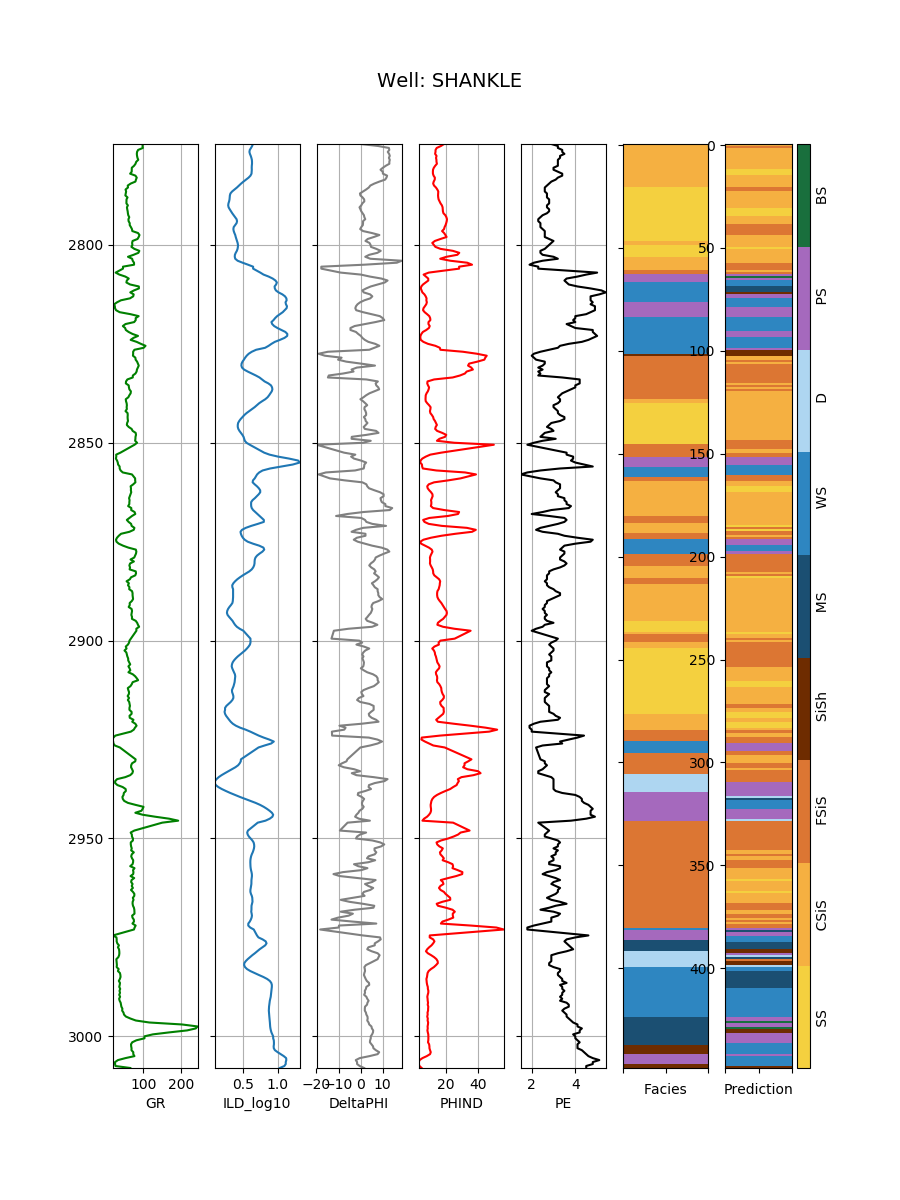

In [44]:
# call well_log_plot_utilities.py 
from well_log_plot_utilities import compare_facies_plot

#compare_facies_plot(df_blind.sort_values(by='Depth'), 'Prediction', facies_colors)
compare_facies_plot(df_blind, 'Prediction', facies_colors)

# Now apply classification model to new/unseen data

New data 'validation_data_nofacies.csv' contains two wells 'STUART' & 'CRAWFORD'. Readin as Dataframe well_data
* Check with Well_data['Well Name'].value_counts() OR
* well_data['Well Name'].values.categories (after .astype('category') OR
* well_data['Well Name'].unique()


In [45]:
well_data = pd.read_csv('validation_data_nofacies.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)

well_features.head()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,66.276,0.630,3.3,10.65,3.591,1,1.000
1,77.252,0.585,6.5,11.95,3.341,1,0.978
2,82.899,0.566,9.4,13.60,3.064,1,0.956
3,80.671,0.593,9.5,13.25,2.977,1,0.933
4,75.971,0.638,8.7,12.35,3.020,1,0.911


Scale data using the same constants we used for the training data. Return ndarray 'X_unknown'

In [46]:
X_unknown = scaler.transform(well_features)

Predict facies labels for the unknown data, and store the results in a Facies column of the test_data dataframe.

In [47]:
y_unknown = clf_fnl.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data.head()

,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies
0,A1 SH,STUART,2808.0,66.276,0.630,3.3,10.65,3.591,1,1.000,3
1,A1 SH,STUART,2808.5,77.252,0.585,6.5,11.95,3.341,1,0.978,3
2,A1 SH,STUART,2809.0,82.899,0.566,9.4,13.60,3.064,1,0.956,3
3,A1 SH,STUART,2809.5,80.671,0.593,9.5,13.25,2.977,1,0.933,3
4,A1 SH,STUART,2810.0,75.971,0.638,8.7,12.35,3.020,1,0.911,1


In [48]:
well_data['Well Name'].values.categories

Index(['CRAWFORD', 'STUART'], dtype='object')

Now call make_facies_plot for unkown data 'well_data'.
* syntax: make_facies_log_plot(logs, facies_colors)

<IPython.core.display.Javascript object>


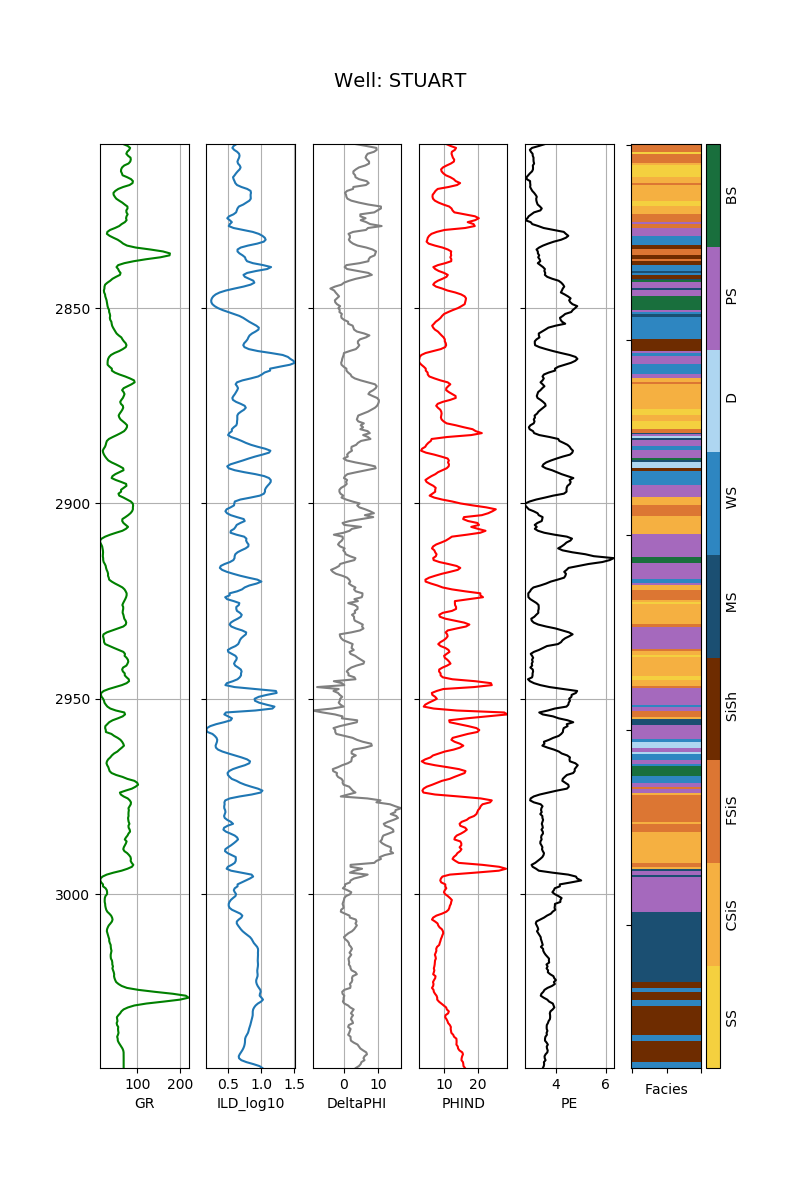

<IPython.core.display.Javascript object>


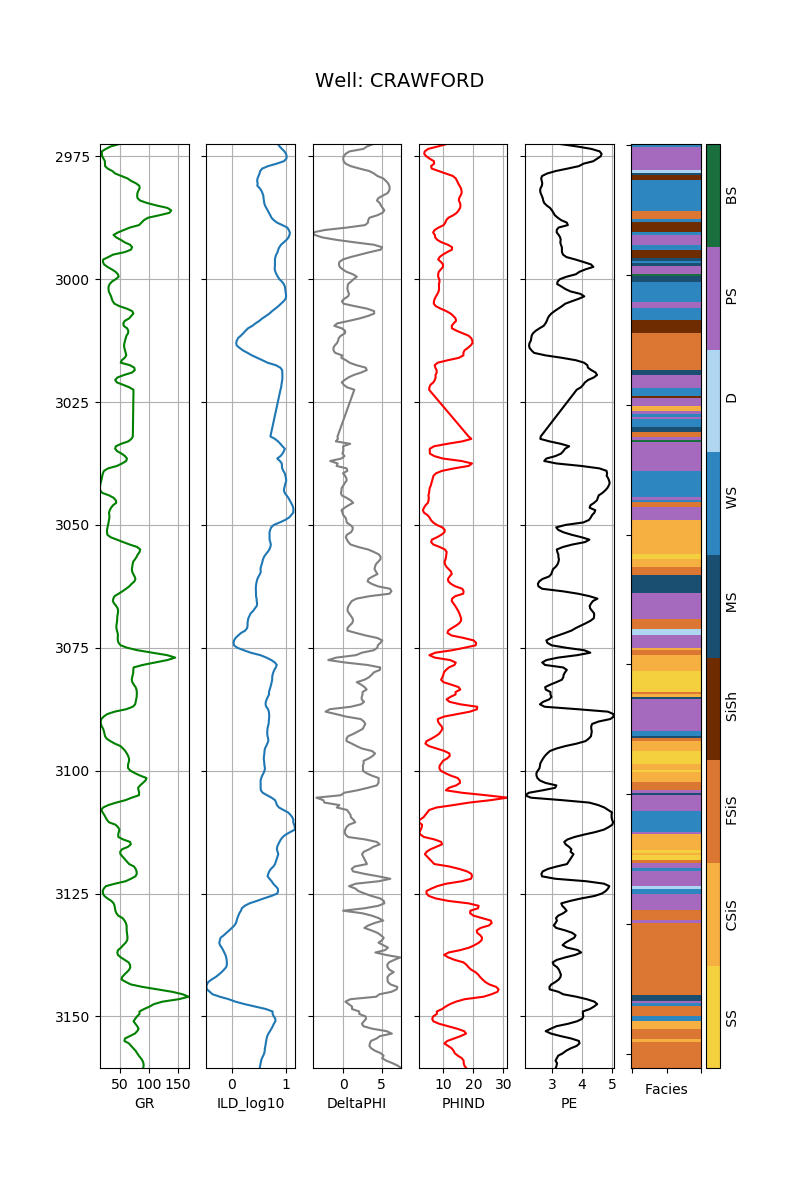

In [49]:
# call functions defined in well_log_plot_utilities.py 
from well_log_plot_utilities import make_facies_log_plot

make_facies_log_plot(
    well_data[well_data['Well Name']=='STUART'], 
    facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name']=='CRAWFORD'], 
    facies_colors)